In [ ]:
import geopandas as gpd
import sys
sys.path.append('/home/lpsha/s154446/fractality/dual_graph_algo/')
import dual_conti

from pyrosm import OSM, get_data
import osmnx as ox
import momepy

import matplotlib.pyplot as plt

import numpy as np

# create a polygon of the bounding box
from shapely.geometry import box

import geopandas as gpd
import pandas as pd
import numpy as np

# map matched

In [168]:
paths = gpd.read_file("/home/lpsha/s154446/fractality/data/traj/Trajectories_0.shp")
paths=paths.to_crs('3857')

In [185]:
paths_proj = paths.to_crs('EPSG:4326')
minx, miny, maxx, maxy = paths_proj.total_bounds  # returns (minx, miny, maxx, maxy)
bbox_polygon = box(minx, miny, maxx, maxy)

In [177]:
G = ox.graph.graph_from_polygon(bbox_polygon)

In [206]:
from importlib import reload
reload(dual_conti)
gdf_merged, _, _, _ = dual_conti.get_dual_dir_con(t_buffer=10, a_threshold=20, data=G, enforce_degree2=False)
gdf_merged.crs = 3857

osmnx graph


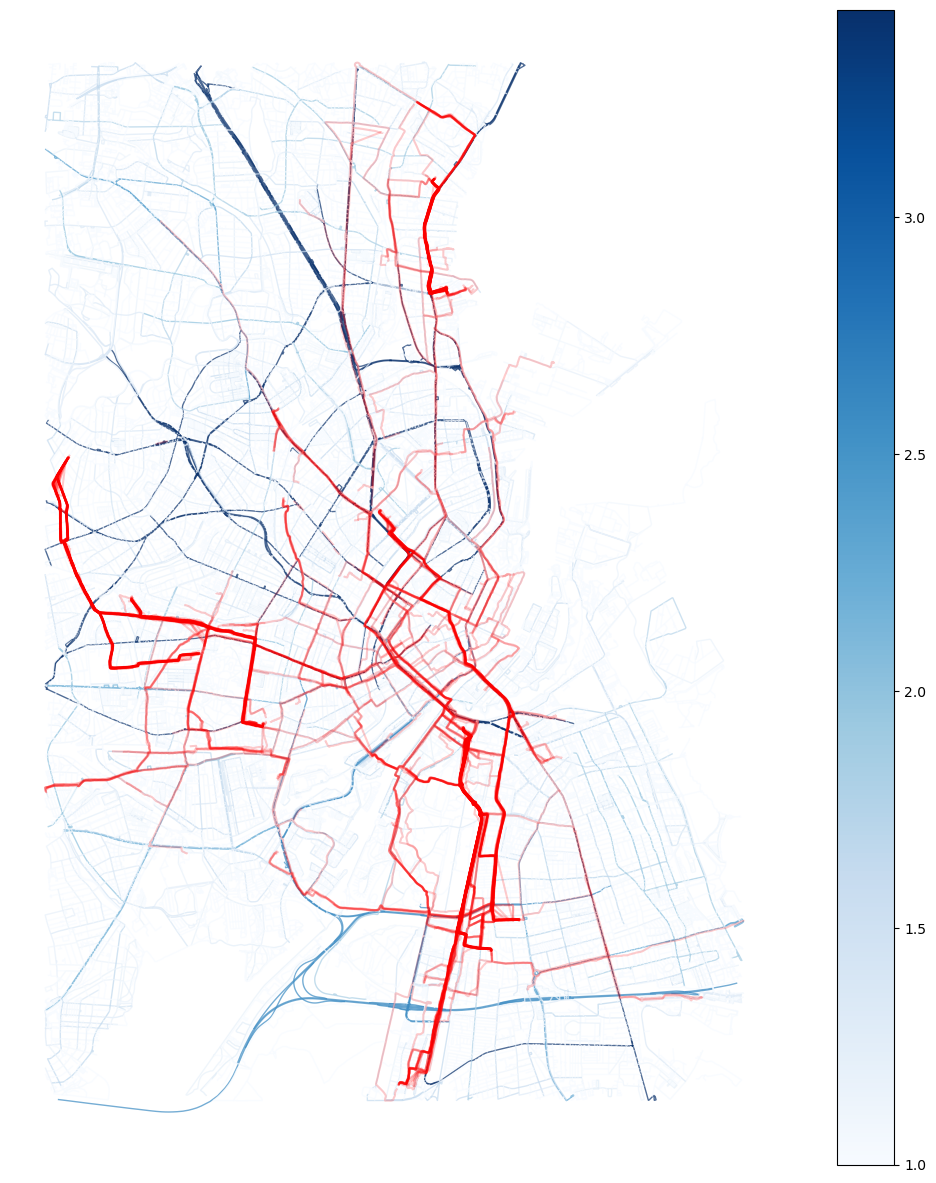

In [252]:
gdf_merged['degree_log'] = gdf_merged.degree.apply(np.log10)
fig, ax = plt.subplots(figsize=(15,15))
gdf_merged.plot(column='degree_log', cmap='Blues', ax=ax, linewidth=1,legend=True,vmin=1,alpha=0.7)
paths.plot(ax=ax,color='red',alpha=0.2)
ax.axis('off')
plt.show()

In [ ]:
# project roads once
roads_proj = gdf_merged.to_crs(epsg=3857)
roads_buffered = roads_proj.geometry.buffer(5)
roads_buffered_gdf = gpd.GeoDataFrame(
    roads_proj.drop(columns='geometry'), 
    geometry=roads_buffered, 
    crs=roads_proj.crs
)

In [243]:
def degree_sequence(path_geom):
    # project path
    path_proj = (
        gpd.GeoSeries([path_geom], crs=paths.crs)
        .to_crs(roads_proj.crs)
        .iloc[0]
    )

    # proportional sampling (≈1 point every 5 m)
    num_points = max(int(path_proj.length // 5), 2)
    distances = np.linspace(0, path_proj.length, num_points)

    # sample points
    points = [path_proj.interpolate(d) for d in distances]
    points_gdf = gpd.GeoDataFrame(geometry=points, crs=roads_proj.crs)

    # buffer points
    points_buffered = gpd.GeoDataFrame(
        geometry=points_gdf.geometry.buffer(5),
        crs=roads_proj.crs
    )

    # spatial join
    joined = gpd.sjoin(
        points_buffered,
        roads_buffered_gdf[['geometry', 'degree']],
        how='left',
        predicate='intersects'
    )

    # return clean degree sequence
    return joined['degree'].dropna().tolist()


# apply to all paths
paths['degree_seq'] = paths.geometry.apply(degree_sequence)

In [ ]:
paths['x'] = paths.degree_seq.apply(lambda x: np.arange(len(x)) / len(x))

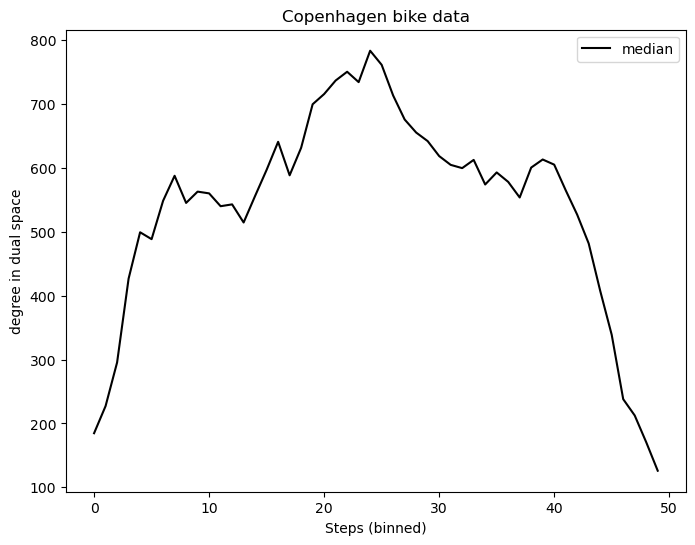

In [298]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)

n_bins = 50
xs_arr = np.concatenate(paths['x'].values)
ys_arr = np.concatenate(paths['degree_seq'].values)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
# bin_means = np.array([ys_arr[idx == i].mean() for i in range(n_bins)])
bin_means = np.array([np.mean(ys_arr[idx == i]) for i in range(n_bins)])
ax.plot(bin_means,label='median',color='k')

plt.legend()
plt.ylabel('degree in dual space')
plt.xlabel('Steps (binned)')

plt.title('Copenhagen bike data')
plt.show()

In [ ]:
#compate with shortest path in G primal or from api! 

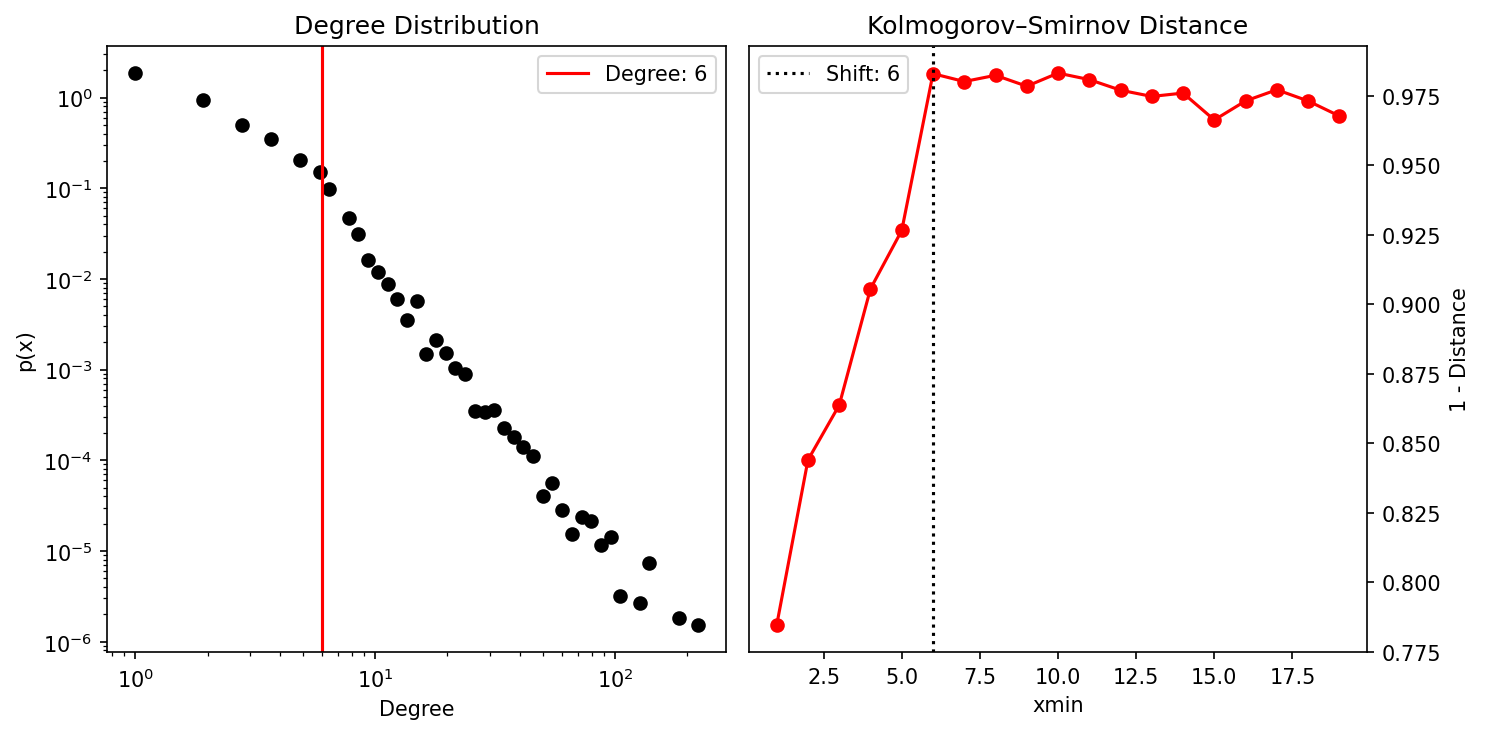

In [294]:
import powerlaw
def compute_ks(degree,min_range):
    distance = []
    for i_min in min_range:
        fit = powerlaw.Fit(degree,discrete=True,xmin=i_min)
        a = fit.alpha
        xmin = fit.xmin
        x_fit = degree[degree>xmin]
        distance.append(fit.power_law.D)

    return np.array(distance), min_range


degree_obs_val = gdf_merged.degree.values

ps = 6

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),dpi=150)
axs = axs.ravel()
ax = axs[0]

# Histogram data
y, x = np.histogram(degree_obs_val, bins=np.logspace(0, np.log10(degree_obs_val.max()), len(np.unique(degree_obs_val))), density=True)
x = x[:-1]
x_nn = x[y != 0][:-1]
y_nn = y[y != 0][:-1]

ax.scatter(x_nn, y_nn, alpha=1, zorder=2, color='k')
ax.axvline(ps,label=f'Degree: {ps}',color='red')
ax.legend()

# Log-log scaling and labels
ax.set_ylabel('p(x)')
ax.set_xlabel('Degree')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title("Degree Distribution")


ks_dist, xmins = compute_ks(degree_obs_val, range(1,20))


ax2 = axs[1]
ax2.scatter(xmins,1-ks_dist,color='red')
ax2.plot(xmins,1-ks_dist,color='red')
ax2.axvline(ps,color='k',linestyle='dotted',label='Shift: '+str(ps))
ax2.set_xlabel('xmin')
ax2.set_ylabel('1 - Distance')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.legend()
ax2.set_title('Kolmogorov–Smirnov Distance')

plt.tight_layout()
plt.show()